# Example of the usage of the Weak label classifier

We first need to load:

1. **Standard Python libraries** for data handling and reproducibility.  
2. **PyTorch** (and its submodules) for model definition, training, and data loading.  
3. **Custom modules** from this project:
   - **`train_test_loop`**: provides the `train_and_evaluate` function to run training and evaluation loops.  
   - **`losses`**: contains various weak‐label‐aware loss functions like `FwdBwdLoss`.  
   - **`weakener`**: implements the `Weakener` class for generating noisy/weak labels.  
   - **`model`**: defines model architectures .
   - **`dataset`**: provides `Data_handling` (and other dataset classes) for loading and splitting data.  


In [1]:
# Standard libraries
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# PyTorch core
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Custom project modules
from utils.train_test_loop import train_and_evaluate
from utils.losses import FwdLoss, EMLoss, FwdBwdLoss, MarginalChainLoss
from utils.losses1 import MarginalChainProperLoss, ForwardProperLoss, scoring_matrix
from utils.losses1 import PiCOLoss, UpperBoundWeakProperLoss
from utils.dataset_visualization import visualize_dataset
from src.weakener import Weakener
from src.model import MLP
from src.dataset import Data_handling

# Set random seeds for reproducibility
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Loading and Visualizing Iris

1. **Instantiate** our `Data_handling` class to load the Iris dataset from OpenML (ID 61) using an 80/20 train/test split.  
2. **Retrieve** the raw arrays of features and labels via `get_data()`.  
3. **Combine** the train and test portions back into a single DataFrame 
4. **Visualize** 

In [2]:
# dataset_name = 'Cifar10'
dataset_name = 'mnist'
Data = Data_handling(
    dataset=dataset_name,
    train_size=0.8,
    test_size=0.2,
    batch_size=64,
    shuffling=False,
    splitting_seed=42,
)

In [3]:
Data.train_dataset.data # This is Train_X
Data.train_dataset.targets # This is Train_y
print(Data.test_dataset.targets)
df = pd.DataFrame(
    Data.train_dataset.data.numpy(),
    columns=[f'feature_{i}' 
             for i in range(Data.train_dataset.data.shape[1])])

df['target'] = [i for i in Data.train_dataset.targets.numpy()]
df.head(3)


tensor([[0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_775,feature_776,feature_777,feature_778,feature_779,feature_780,feature_781,feature_782,feature_783,target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."


In [4]:
Data.num_classes

10

In [5]:
""" df_2_plot = df.iloc[0:1000]
features = ['feature_102', 'feature_103']
visualize_dataset(
    df_2_plot,
    features=features,
    classes=Data.num_classes,
    title=dataset_name,
) """


" df_2_plot = df.iloc[0:1000]\nfeatures = ['feature_102', 'feature_103']\nvisualize_dataset(\n    df_2_plot,\n    features=features,\n    classes=Data.num_classes,\n    title=dataset_name,\n) "

In [6]:
""" df_2_plot[[features[0], features[1]]] """


' df_2_plot[[features[0], features[1]]] '

Next, we’ll simulate a **partial‐label learning** or **noisy-label** setting by corrupting each true label with **M**:

1. **Instantiate** a `Weakener` with the number of true classes.  
2. **Build** a mixing matrix via `generate_M(model_class='pll', corr_p=…)` 
3. **Generate** weak labels with `generate_weak`, which returns:
   - `z`: the integer index of the weak‐label   
   - `w`: a binary matrix of shape `(n_samples, n_classes)` indicating the candidate labels  
4. **Insert** the partial labels into our Data using `include_weak(w)`.  

In [7]:
corr_p = 0.2
weakener = Weakener(true_classes=Data.num_classes)
weakener.generate_M(model_class='pll', corr_p=0.2)
# weakener.generate_M(model_class='unif_noise', corr_p=0.5) #Try this for noisy labels

print(f"Generated M matrix:\n"
      f"{np.array2string(weakener.M, precision=4, suppress_small=True)}")

true_onehot = Data.train_dataset.targets  # shape: (n_samples, n_classes)

z = weakener.generate_weak(true_onehot)
print(f"Generated z (noisy labels):\n{z}")

Data.include_weak(z)

# Compute virtual labels
print("Computing virtual labels...")
# Since z[i] is an integer, row i must contain the z[i]-th row of weakener.Z
virtual_labels = weakener.Z[z]

Data.include_virtual(virtual_labels, initial_weight=1/Data.num_classes)

train_loader, test_loader = Data.get_dataloader(
    weak_labels='all', get_index=True)

Generated M matrix:
[[0.     0.     0.     ... 0.     0.     0.1342]
 [0.     0.     0.     ... 0.     0.1342 0.    ]
 [0.     0.     0.     ... 0.     0.0336 0.0336]
 ...
 [0.     0.     0.     ... 0.     0.     0.    ]
 [0.     0.     0.     ... 0.     0.     0.    ]
 [0.     0.     0.     ... 0.     0.     0.    ]]
Generated z (noisy labels):
tensor([144, 648, 176,  ...,  17,  23,  18], dtype=torch.int32)
Computing virtual labels...


In [8]:
batch = next(iter(train_loader))
xb, wb, vb, cb, yb, ib = batch
print(f"Inputs batch: shape {xb.shape}")
print(f"Weak (partial) labels: shape {wb.shape}, first row: {wb[0]}")
print(f"Virtual labels: shape {vb.shape}, first row: {vb[0]}")
print(f"Weights: shape {cb.shape}, first row: {cb[0]}")
print(f"True one-hot labels shape: {yb.shape}, first row: {yb[0]}")
print(f"Indices batch: shape {ib.shape}, first row: {ib[0]}")

Inputs batch: shape torch.Size([64, 784])
Weak (partial) labels: shape torch.Size([64]), first row: 144
Virtual labels: shape torch.Size([64, 10]), first row: tensor([0, 0, 1, 0, 0, 1, 0, 0, 0, 1])
Weights: shape torch.Size([64, 10]), first row: tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000])
True one-hot labels shape: torch.Size([64, 10]), first row: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
Indices batch: shape torch.Size([64]), first row: 0


In [9]:
weak_df = pd.DataFrame(Data.train_dataset.data.numpy(), columns=[f'feature_{i}' for i in range(Data.train_dataset.data.shape[1])])
df['target'] = [i for i in weakener.w.numpy()]

In [10]:
# visualize_dataset(
#     df,
#     features=['feature_0', 'feature_1'],
#     classes=3,
#     title='Iris Samples with Pie Markers for Multi-Label Entries'
# )



1. **Instantiate** the model (e.g. `MLP`) with its input/output dimensions.   
2. **Choose** the optimizer and set hyperparameters.  
3. **Define** the loss function.

We also could do a learning rate scheduler (e.g. `StepLR`) to decrease the LR over time. 

## Training the MLP (using `train_test_loop.py`)

1. **Set** training hyperparameters  
2. **Call** `train_and_evaluate(model, train_loader, test_loader, optimizer, pll_loss, num_epochs, corr_p)`
3. **Plot** results

Using device: cpu
Initializing MLP model...
784
[]
10
tensor([[0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        ...,
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000]])
Starting epoch 1/5
Starting epoch 2/5
Starting epoch 3/5
Starting epoch 4/5
Starting epoch 5/5
   epoch  train_loss  train_acc  test_acc  train_detached_loss  \
0      1    0.080649   0.808367    0.8755             0.008663   
1      2    0.075591   0.879083    0.8958             0.006607   
2      3    0.074689   0.893717    0.9044             0.005850   
3      4    0.074280   0.901367    0.9104             0.005446   
4      5    0.074040   0.906417    0.9141             0.005191   

   test_detached_loss optimizer loss_fn repetition  init

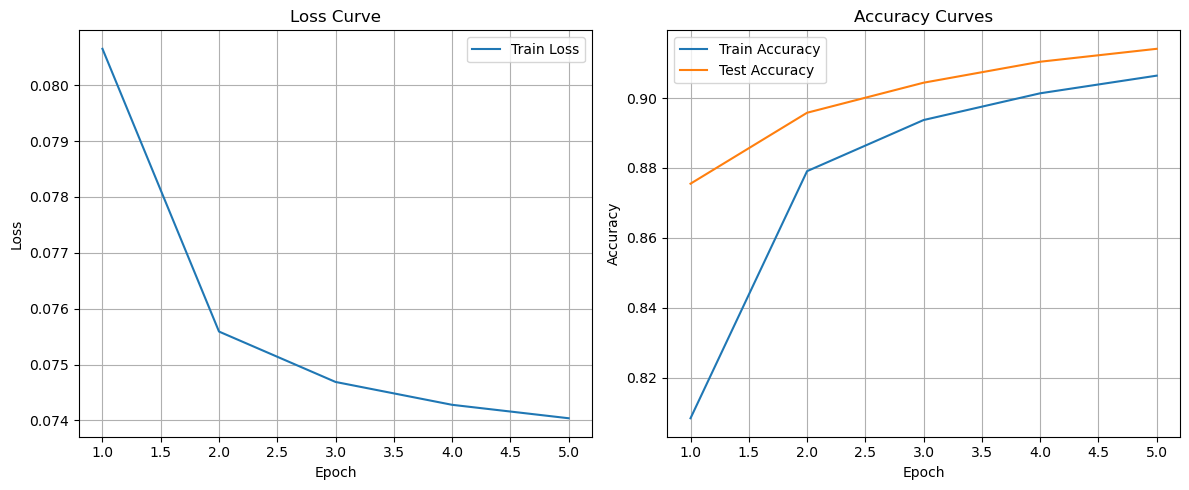

In [11]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = MLP(
    input_size=Data.num_features,
    hidden_sizes=[],
    output_size=Data.num_classes,
    dropout_p=0,
    bn=False,
    activation='relu'
)

optimizer = optim.Adam(
    model.parameters(),
    lr=1e-6,
)

#optimizer = optim.SGD(
#    model.parameters(),
#    lr=0.01,
#    momentum=0.0  # 0.9
#)

# 2. Training parameters
num_epochs = 5

em_loss = MarginalChainProperLoss(weakener.M, loss_code="cross_entropy")

# 3. Run the training + evaluation loop
model, results_df = train_and_evaluate(
    model,        # our MLP on device
    train_loader, # yields (x, w, y)
    test_loader,  # yields (x, y)
    optimizer,    # Adam optimizer
    em_loss,      # EMLoss with our PLL mixing matrix
    num_epochs,   # total epochs
    corr_p        # used for logging consistency
)

# 4. View the epoch‐by‐epoch results
print(results_df)

# Set up a wide figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss curves
ax1.plot(results_df['epoch'], results_df['train_loss'], label='Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curve')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(results_df['epoch'], results_df['train_acc'], label='Train Accuracy')
ax2.plot(results_df['epoch'], results_df['test_acc'], label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Curves')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


Using device: cpu
Initializing MLP model...
784
[]
10
tensor([[0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        ...,
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000]])
Starting epoch 1/10
Shape of Q: torch.Size([64, 10])
Shape of logp: torch.Size([64, 10])
Shape of Q: torch.Size([64, 10])
Shape of logp: torch.Size([64, 10])
Shape of Q: torch.Size([64, 10])
Shape of logp: torch.Size([64, 10])
Shape of Q: torch.Size([64, 10])
Shape of logp: torch.Size([64, 10])
Shape of Q: torch.Size([64, 10])
Shape of logp: torch.Size([64, 10])
Shape of Q: torch.Size([64, 10])
Shape of logp: torch.Size([64, 10])
Shape of Q: torch.Size([64, 10])
Shape of logp: torch.Size([64, 10])
Shape of Q: torch.Size([64, 10])
Shape of log

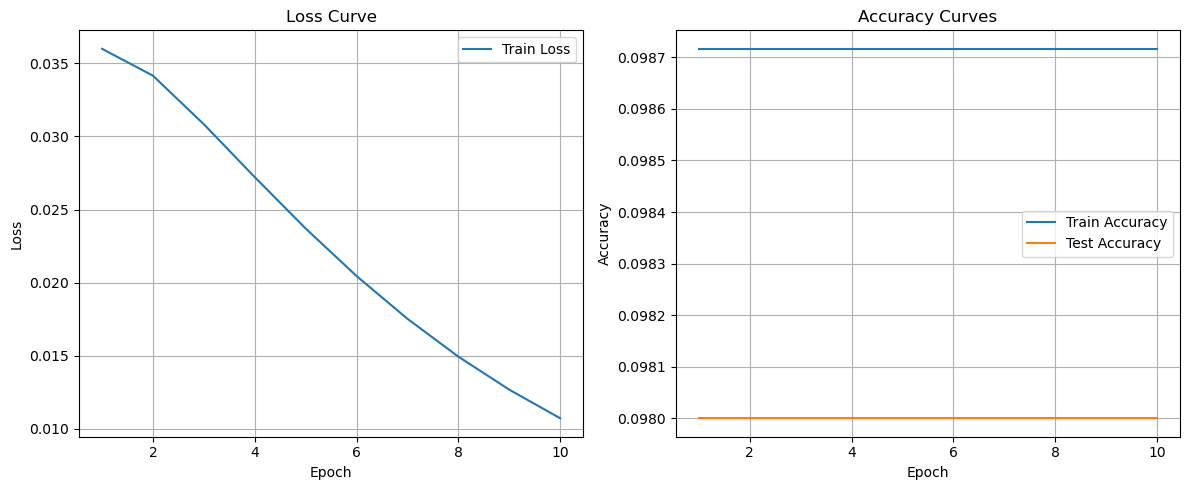

In [12]:
# #################
# Testing PiCO Loss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = MLP(
    input_size=Data.num_features,
    hidden_sizes=[],
    output_size=Data.num_classes,
    dropout_p=0,
    bn=False,
    activation='relu'
)

optimizer = optim.Adam(
    model.parameters(),
    lr=1e-6,
)

#optimizer = optim.SGD(
#    model.parameters(),
#    lr=0.01,
#    momentum=0.0  # 0.9
#)

# 2. Training parameters
num_epochs = 10

em_loss = PiCOLoss(loss_code="cross_entropy")

# 3. Run the training + evaluation loop
model, results_df = train_and_evaluate(
    model,        # our MLP on device
    train_loader, # yields (x, w, y)
    test_loader,  # yields (x, y)
    optimizer,    # Adam optimizer
    em_loss,      # EMLoss with our PLL mixing matrix
    num_epochs,   # total epochs
    corr_p,        # used for logging consistency
    loss_type='PiCO'
)

# 4. View the epoch‐by‐epoch results
print(results_df)

# Set up a wide figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss curves
ax1.plot(results_df['epoch'], results_df['train_loss'], label='Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curve')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(results_df['epoch'], results_df['train_acc'], label='Train Accuracy')
ax2.plot(results_df['epoch'], results_df['test_acc'], label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Curves')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import os
print(os.getenv("PYTHONBREAKPOINT"))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = MLP(
    input_size=Data.num_features,
    hidden_sizes=[],
    output_size=Data.num_classes,
    dropout_p=0,
    bn=False,
    activation='relu'
)

optimizer = optim.Adam(
    model.parameters(),
    lr=1e-6,
)

# 2. Training parameters
num_epochs = 60

#em_loss = FwdLoss(weakener.M)
em_loss = ForwardProperLoss(weakener.M, loss_code="cross_entropy")
#em_loss = MarginalChainProperLoss(weakener.M, loss_code="cross_entropy")

# 3. Run the training + evaluation loop
model, results_df = train_and_evaluate(
    model,        # our MLP on device
    train_loader, # yields (x, w, y)
    test_loader,  # yields (x, y)
    optimizer,    # Adam optimizer
    em_loss,     # EMLoss with our PLL mixing matrix
    num_epochs,   # total epochs
    corr_p        # used for logging consistency
)

# 4. View the epoch‐by‐epoch results
print(results_df)

# Set up a wide figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss curves
ax1.plot(results_df['epoch'], results_df['train_loss'], label='Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curve')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(results_df['epoch'], results_df['train_acc'], label='Train Accuracy')
ax2.plot(results_df['epoch'], results_df['test_acc'], label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Curves')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import torch
from torch import nn

# 1. 固定随机种子
torch.manual_seed(0)

B, C = 5, 4

logits = torch.randn(B, C, requires_grad=True)
z = torch.randint(0, C, (B,))

M = torch.rand(C, C)
M = M / M.sum(dim=1, keepdim=True)
F = M.clone()

# 这里贴上你的 MarginalChainProperLoss 和 ForwardProperLoss 定义
# loss_code="cross_entropy"

mc_loss_fn = MarginalChainProperLoss(M, loss_code="cross_entropy", reduction="mean")
fw_loss_fn = ForwardProperLoss(F, loss_code="cross_entropy", reduction="mean")

# Marginal chain
logits_mc = logits.clone().detach().requires_grad_(True)
loss_mc = mc_loss_fn(logits_mc, z)
loss_mc.backward()
grad_mc = logits_mc.grad.clone().detach()

# Forward
logits_fw = logits.clone().detach().requires_grad_(True)
loss_fw = fw_loss_fn(logits_fw, z)
loss_fw.backward()
grad_fw = logits_fw.grad.clone().detach()

print("loss_mc:", loss_mc.item())
print("loss_fw:", loss_fw.item())
print("loss diff:", abs(loss_mc.item() - loss_fw.item()))

print("grad same?", torch.allclose(grad_mc, grad_fw, atol=1e-6))
print("grad max diff:", (grad_mc - grad_fw).abs().max().item())


In [ ]:
# 取一个 batch
xb, zb, yb = next(iter(train_loader))   # 确保 zb 就是 z（weak index）
xb = xb.to(device)
zb = zb.to(device)

logits = model(xb)

fwd_loss_fn = ForwardProperLoss(weakener.M, "cross_entropy").to(device)
ub_loss_fn  = UpperBoundWeakProperLoss(weakener.M, "cross_entropy").to(device)

loss_fwd = fwd_loss_fn(logits, zb)
loss_ub  = ub_loss_fn(logits, zb)

print("loss_fwd:", loss_fwd.item())
print("loss_ub :", loss_ub.item())

g1 = torch.autograd.grad(loss_fwd, logits, retain_graph=True)[0]
g2 = torch.autograd.grad(loss_ub,  logits)[0]
print("grad norm fwd:", g1.norm().item())
print("grad norm ub :",  g2.norm().item())


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = MLP(
    input_size=Data.num_features,
    hidden_sizes=[],
    output_size=Data.num_classes,
    dropout_p=0,
    bn=False,
    activation='relu'
)

optimizer = optim.Adam(
    model.parameters(),
    lr=1e-6,
)


# 2. Training parameters
num_epochs = 60

#em_loss = FwdLoss(weakener.M)
em_loss = UpperBoundWeakProperLoss(weakener.M, loss_code="cross_entropy")
#em_loss = MarginalChainProperLoss(weakener.M, loss_code="cross_entropy")

# 3. Run the training + evaluation loop
model, results_df = train_and_evaluate(
    model,        # our MLP on device
    train_loader, # yields (x, w, y)
    test_loader,  # yields (x, y)
    optimizer,    # Adam optimizer
    em_loss,     # EMLoss with our PLL mixing matrix
    num_epochs,   # total epochs
    corr_p        # used for logging consistency
)

# 4. View the epoch‐by‐epoch results
print(results_df)

# Set up a wide figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss curves
ax1.plot(results_df['epoch'], results_df['train_loss'], label='Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curve')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(results_df['epoch'], results_df['train_acc'], label='Train Accuracy')
ax2.plot(results_df['epoch'], results_df['test_acc'], label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Curves')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = MLP(
    input_size=Data.num_features,
    hidden_sizes=[],
    output_size=Data.num_classes,
    dropout_p=0,
    bn=False,
    activation='relu'
)

optimizer = optim.Adam(
    model.parameters(),
    lr=1e-6,
)
# 2. Training parameters
num_epochs = 60

em_loss = MarginalChainProperLoss(weakener.M, loss_code="ps_2")

# 3. Run the training + evaluation loop
model, results_df = train_and_evaluate(
    model,        # our MLP on device
    train_loader, # yields (x, w, y)
    test_loader,  # yields (x, y)
    optimizer,    # Adam optimizer
    em_loss,     # EMLoss with our PLL mixing matrix
    num_epochs,   # total epochs
    corr_p        # used for logging consistency
)

# 4. View the epoch‐by‐epoch results
print(results_df)

# Set up a wide figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss curves
ax1.plot(results_df['epoch'], results_df['train_loss'], label='Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curve')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(results_df['epoch'], results_df['train_acc'], label='Train Accuracy')
ax2.plot(results_df['epoch'], results_df['test_acc'], label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Curves')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = MLP(
    input_size=Data.num_features,
    hidden_sizes=[],
    output_size=Data.num_classes,
    dropout_p=0,
    bn=False,
    activation='relu'
)

optimizer = optim.Adam(
    model.parameters(),
    lr=0.015,
)
# 2. Training parameters
num_epochs = 90

em_loss = ForwardProperLoss(weakener.M, loss_code="ps_2")

# 3. Run the training + evaluation loop
model, results_df = train_and_evaluate(
    model,        # our MLP on device
    train_loader, # yields (x, w, y)
    test_loader,  # yields (x, y)
    optimizer,    # Adam optimizer
    em_loss,     # EMLoss with our PLL mixing matrix
    num_epochs,   # total epochs
    corr_p        # used for logging consistency
)

# 4. View the epoch‐by‐epoch results
print(results_df)

# Set up a wide figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss curves
ax1.plot(results_df['epoch'], results_df['train_loss'], label='Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curve')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(results_df['epoch'], results_df['train_acc'], label='Train Accuracy')
ax2.plot(results_df['epoch'], results_df['test_acc'], label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Curves')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = MLP(
    input_size=Data.num_features,
    hidden_sizes=[],
    output_size=Data.num_classes,
    dropout_p=0,
    bn=False,
    activation='relu'
)

optimizer = optim.Adam(
    model.parameters(),
    lr=1e-6,
)
# 2. Training parameters
num_epochs = 60

em_loss = UpperBoundWeakProperLoss(weakener.M, loss_code="ps_2")

# 3. Run the training + evaluation loop
model, results_df = train_and_evaluate(
    model,        # our MLP on device
    train_loader, # yields (x, w, y)
    test_loader,  # yields (x, y)
    optimizer,    # Adam optimizer
    em_loss,     # EMLoss with our PLL mixing matrix
    num_epochs,   # total epochs
    corr_p        # used for logging consistency
)

# 4. View the epoch‐by‐epoch results
print(results_df)

# Set up a wide figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss curves
ax1.plot(results_df['epoch'], results_df['train_loss'], label='Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curve')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(results_df['epoch'], results_df['train_acc'], label='Train Accuracy')
ax2.plot(results_df['epoch'], results_df['test_acc'], label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Curves')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = MLP(
    input_size=Data.num_features,
    hidden_sizes=[],
    output_size=Data.num_classes,
    dropout_p=0,
    bn=False,
    activation='relu'
)

optimizer = optim.Adam(
    model.parameters(),
    lr=0.015,
)
# 2. Training parameters
num_epochs = 400

em_loss = MarginalChainProperLoss(weakener.M, loss_code="tsallis_0.2")

# 3. Run the training + evaluation loop
model, results_df = train_and_evaluate(
    model,        # our MLP on device
    train_loader, # yields (x, w, y)
    test_loader,  # yields (x, y)
    optimizer,    # Adam optimizer
    em_loss,     # EMLoss with our PLL mixing matrix
    num_epochs,   # total epochs
    corr_p        # used for logging consistency
)

# 4. View the epoch‐by‐epoch results
print(results_df)

# Set up a wide figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss curves
ax1.plot(results_df['epoch'], results_df['train_loss'], label='Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curve')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(results_df['epoch'], results_df['train_acc'], label='Train Accuracy')
ax2.plot(results_df['epoch'], results_df['test_acc'], label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Curves')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = MLP(
    input_size=Data.num_features,
    hidden_sizes=[],
    output_size=Data.num_classes,
    dropout_p=0,
    bn=False,
    activation='relu'
)

optimizer = optim.Adam(
    model.parameters(),
    lr=1e-6,
)
# 2. Training parameters
num_epochs = 60

em_loss = ForwardProperLoss(weakener.M, loss_code="tsallis_0.5")

# 3. Run the training + evaluation loop
model, results_df = train_and_evaluate(
    model,        # our MLP on device
    train_loader, # yields (x, w, y)
    test_loader,  # yields (x, y)
    optimizer,    # Adam optimizer
    em_loss,     # EMLoss with our PLL mixing matrix
    num_epochs,   # total epochs
    corr_p        # used for logging consistency
)

# 4. View the epoch‐by‐epoch results
print(results_df)

# Set up a wide figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss curves
ax1.plot(results_df['epoch'], results_df['train_loss'], label='Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curve')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(results_df['epoch'], results_df['train_acc'], label='Train Accuracy')
ax2.plot(results_df['epoch'], results_df['test_acc'], label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Curves')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = MLP(
    input_size=Data.num_features,
    hidden_sizes=[],
    output_size=Data.num_classes,
    dropout_p=0,
    bn=False,
    activation='relu'
)

optimizer = optim.Adam(
    model.parameters(),
    lr=1e-6,
)
# 2. Training parameters
num_epochs = 60

em_loss = UpperBoundWeakProperLoss(weakener.M, loss_code="tsallis_0.2")

# 3. Run the training + evaluation loop
model, results_df = train_and_evaluate(
    model,        # our MLP on device
    train_loader, # yields (x, w, y)
    test_loader,  # yields (x, y)
    optimizer,    # Adam optimizer
    em_loss,     # EMLoss with our PLL mixing matrix
    num_epochs,   # total epochs
    corr_p        # used for logging consistency
)

# 4. View the epoch‐by‐epoch results
print(results_df)

# Set up a wide figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss curves
ax1.plot(results_df['epoch'], results_df['train_loss'], label='Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curve')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(results_df['epoch'], results_df['train_acc'], label='Train Accuracy')
ax2.plot(results_df['epoch'], results_df['test_acc'], label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Curves')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Set up a wide figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Loss curves
ax1.plot(results_df['epoch'], results_df['train_loss'], label='Weak Train Loss')
ax1.plot(clean_results['epoch'], clean_results['train_loss'], label='Supervised Train Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curve')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(results_df['epoch'], results_df['train_acc'], label='Weak Train Accuracy')
ax2.plot(results_df['epoch'], results_df['test_acc'], label='Weak Test Accuracy')
ax2.plot(clean_results['epoch'], clean_results['train_acc'],'--', label='Supervised Train Accuracy' )
ax2.plot(clean_results['epoch'], clean_results['test_acc'], '--', label='Supervied Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Curves')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()